In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load clean data
df = pd.read_csv("../data/processed/cleaned_transactions.csv")
df['invoice_date'] =  pd.to_datetime(df['invoice_date'])

In [3]:
# Prepare data
snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)

In [4]:
rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date-x.max()).days,
    'invoice': 'nunique',
    'total_amount': 'sum'
}).reset_index()

In [5]:
rfm.rename(columns={
    'invoice_date': 'recency',
    'invoice': 'frequency',
    'total_amount': 'monetary'
}, inplace=True)

In [6]:
print(f"Total customers: {len(rfm)}")
print(rfm.head())

Total customers: 5881
   customer_id  recency  frequency  monetary
0      12346.0      326         12  77556.46
1      12347.0        2          8   5633.32
2      12348.0       75          5   2019.40
3      12349.0       19          4   4428.69
4      12350.0      310          1    334.40


In [7]:
rfm_sorted = rfm.sort_values(by='monetary', ascending=False)
top_20_percent = int(len(rfm)*0.2)
revenue_from_top_20 = rfm_sorted.iloc[:top_20_percent]['monetary'].sum()
total_revenue = rfm_sorted['monetary'].sum()

In [9]:
print(f"\nInsight: The top 20% of customers generate {revenue_from_top_20/total_revenue:.1%} of total revenue.")


Insight: The top 20% of customers generate 77.3% of total revenue.


c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\rohan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


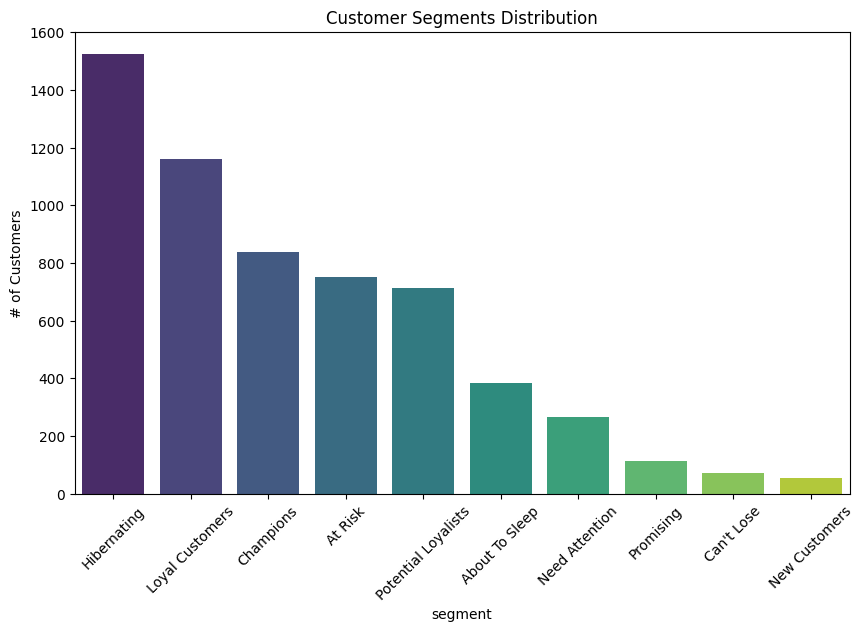

We have 837 Champions.
Average Spend of a Champion: £10,901.13


In [ ]:
# 1. Create RFM Scores (1-5 scale)
# We use qcut to split data into 5 equal percentiles
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1]) # Note: Low recency days = High score (5)
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# 2. Combine R and F into a single string (e.g., "55", "15")
# We focus on Recency and Frequency for segmentation 
rfm['rf_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str)

# 3. Map Scores to Segment Names (The "Segment Map")

seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['segment'] = rfm['rf_score'].replace(seg_map, regex=True)

# 4. Visualize the Segments
segment_counts = rfm['segment'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xticks(rotation=45)
plt.ylabel('# of Customers')
plt.show()

# 5. Who are our "Champions"? (The VIPs)
champs = rfm[rfm['segment'] == 'Champions']
print(f"We have {len(champs)} Champions.")
print(f"Average Spend of a Champion: £{champs['monetary'].mean():,.2f}")